Train Columns: Index(['filename', 'label'], dtype='object')
Test Columns: Index(['filename'], dtype='object')
Missing file: /kaggle/input/dataset/audios_test/audio_177.wav
Missing file: /kaggle/input/dataset/audios_test/audio_435.wav
Missing file: /kaggle/input/dataset/audios_test/audio_300.wav
Missing file: /kaggle/input/dataset/audios_test/audio_521.wav
Missing file: /kaggle/input/dataset/audios_test/audio_165.wav
Missing file: /kaggle/input/dataset/audios_test/audio_519.wav
Missing file: /kaggle/input/dataset/audios_test/audio_564.wav
Missing file: /kaggle/input/dataset/audios_test/audio_235.wav
Missing file: /kaggle/input/dataset/audios_test/audio_422.wav
Mean Squared Error: 0.9937483848314607
Pearson Correlation: 0.537536730628543


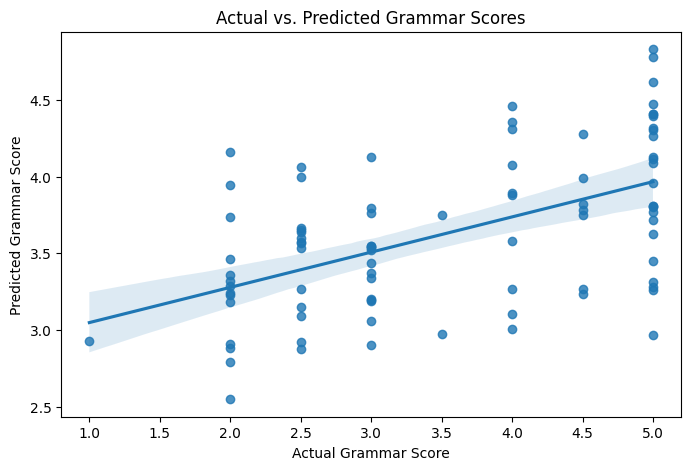

Submission file saved as /kaggle/working/sample_submission.csv


In [8]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Load datasets
train_df = pd.read_csv("/kaggle/input/dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/dataset/test.csv")

# Debugging: Print column names to check for issues
print("Train Columns:", train_df.columns)
print("Test Columns:", test_df.columns)

# Ensure correct column name
audio_column = "filename" if "filename" in train_df.columns else train_df.columns[0]
label_column = "grammar_score" if "grammar_score" in train_df.columns else train_df.columns[1]

# Function to extract audio features
def extract_audio_features(audio_path, sr=22050):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        features = {
            "mfcc_mean": np.mean(librosa.feature.mfcc(y=y, sr=sr)),
            "mfcc_std": np.std(librosa.feature.mfcc(y=y, sr=sr)),
            "chroma_mean": np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
            "chroma_std": np.std(librosa.feature.chroma_stft(y=y, sr=sr)),
            "spectral_centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
            "spectral_rolloff": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
            "zero_crossing_rate": np.mean(librosa.feature.zero_crossing_rate(y)),
            "rms_energy": np.mean(librosa.feature.rms(y=y))
        }
        return features
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Extract features for training data
train_features = []
valid_files = []
for file in train_df[audio_column]:
    audio_path = os.path.join("/kaggle/input/dataset/audios_train", file)
    if os.path.exists(audio_path):
        features = extract_audio_features(audio_path)
        if features:
            train_features.append(features)
            valid_files.append(file)
    else:
        print(f"Missing file: {audio_path}")

train_features_df = pd.DataFrame(train_features)
train_df = train_df[train_df[audio_column].isin(valid_files)]  # Filter valid files
train_data = pd.concat([train_df.reset_index(drop=True), train_features_df.reset_index(drop=True)], axis=1)

# Extract features for test data
test_features = []
valid_test_files = []
for file in test_df[audio_column]:
    audio_path = os.path.join("/kaggle/input/dataset/audios_test", file)
    if os.path.exists(audio_path):
        features = extract_audio_features(audio_path)
        if features:
            test_features.append(features)
            valid_test_files.append(file)
    else:
        print(f"Missing file: {audio_path}")

test_features_df = pd.DataFrame(test_features)
test_df = test_df[test_df[audio_column].isin(valid_test_files)]  # Filter valid files
test_data = pd.concat([test_df.reset_index(drop=True), test_features_df.reset_index(drop=True)], axis=1)

# Define features and target
X = train_data.drop(columns=[label_column, audio_column])
y = train_data[label_column]

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_features_df)

# Train model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate model
y_val_pred = model.predict(X_val_scaled)
mse = mean_squared_error(y_val, y_val_pred)
pearson_corr, _ = pearsonr(y_val, y_val_pred)
print(f"Mean Squared Error: {mse}")
print(f"Pearson Correlation: {pearson_corr}")

# Visualization
plt.figure(figsize=(8, 5))
sns.regplot(x=y_val, y=y_val_pred)
plt.xlabel("Actual Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Actual vs. Predicted Grammar Scores")
plt.show()

# Generate test predictions
test_predictions = model.predict(X_test_scaled)

# Prepare submission file
submission = pd.DataFrame({audio_column: test_df[audio_column], "grammar_score": test_predictions})

# Save correctly to working directory
submission.to_csv("/kaggle/working/sample_submission.csv", index=False)
print("Submission file saved as /kaggle/working/sample_submission.csv")


In [9]:
pd.read_csv("/kaggle/input/dataset/sample_submission.csv").head()


,filename,label
0,audio_706.wav,0
1,audio_800.wav,0
2,audio_68.wav,0
3,audio_1267.wav,0
4,audio_683.wav,0
